# 自己相関時間のテスト

## import

In [21]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbars
import matplotlib.gridspec as gridspec
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import datetime
import os
import time
import pathlib
import sys
import uncertainties
import pickle
from uncertainties import ufloat

import made
from made import MADE
import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

seed = None
random.seed(seed)
rng = np.random.default_rng(seed)
#generator = torch.Generator().manual_seed(seed)

## インスタンス取得

In [22]:
beta = 5.0
n_spin = 10

# get result of spectral gap
gap_data = np.load("result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta)))
print(gap_data.shape)

# import instance sets
source_dir_name = 'data/instance_set_2024-0614-1705-31'
fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_instance_set.pickle'.format(n_spin))
with open(str(fname_in), 'rb') as f:
	instance_set = pickle.load(f)
 
# import an instance
idx = 0
gap = gap_data[:,idx]
instance = instance_set[idx]

(5, 100)


## MCMCシミュレーション

### settings

In [23]:
# QAOA
n_layers = 5
qaoa_init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
qaoa_method = "BFGS"
qaoa_options = {"disp": False, "maxiter": 200, "gtol": 1e-6}

# MADE
n_train = 1000
n_test = int(n_train * 0.25)
hidden_size = int(2 * n_spin)
hidden_layers = 2
batchsize = 8
lr = 0.005
n_epochs = 30

# mcmc
n_chain = 10
n_step = 1000

### simulation

In [24]:
# optimize QAOA ansatz
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def qaoa_cost(para):
	return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

if qaoa_init_para == None:
	qaoa_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
else:
	qaoa_para = qaoa_init_para
 
qaoa_opt = scipy.optimize.minimize(qaoa_cost, qaoa_para, method=qaoa_method, options=qaoa_options)

# sampling from QAOA distribution
qaoa_opt_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_opt.x, n_train+n_test) # optimize parameter
qaoa_fix_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_init_para, n_train+n_test) # fixed angle

qaoa_opt_data_nd = np.array([qaoa.number_to_binary(qaoa_opt_data_idx[i], n_spin) for i in range(len(qaoa_opt_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
qaoa_fix_data_nd = np.array([qaoa.number_to_binary(qaoa_fix_data_idx[i], n_spin) for i in range(len(qaoa_fix_data_idx))], dtype='float32')

qaoa_opt_data = torch.from_numpy(qaoa_opt_data_nd).to(dtype=torch.float32)
qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test])
qaoa_fix_data = torch.from_numpy(qaoa_fix_data_nd).to(dtype=torch.float32)
qaoa_fix_traindata, qaoa_fix_testdata = torch.utils.data.random_split(dataset=qaoa_fix_data, lengths=[n_train, n_test])

qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=True)
qaoa_fix_testset = torch.utils.data.DataLoader(qaoa_fix_testdata, batch_size=batchsize, shuffle=False)
qaoa_fix_trainset = torch.utils.data.DataLoader(qaoa_fix_traindata, batch_size=batchsize, shuffle=True)

# learn MADE by QAOA samples
hidden_list = [hidden_size for i in range(hidden_layers)]

model_qaoa_opt = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
model_qaoa_fix = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)

opt_qaoa_opt = torch.optim.Adam(model_qaoa_opt.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt, step_size=45, gamma=0.1)
opt_qaoa_fix = torch.optim.Adam(model_qaoa_fix.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_fix = torch.optim.lr_scheduler.StepLR(opt_qaoa_fix, step_size=45, gamma=0.1)

made.run_train(model_qaoa_opt, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt, scheduler_qaoa_opt, seed)
made.run_train(model_qaoa_fix, qaoa_fix_trainset, qaoa_fix_testset, n_epochs, opt_qaoa_fix ,scheduler_qaoa_fix, seed)

# sampling to models and compute the probability of these outputs
opt_qaoa_made_outputs_nd = made.predict(model_qaoa_opt, n_step)
opt_qaoa_made_outputs_spin = np.array([made.binary_to_spin(opt_qaoa_made_outputs_nd[i]) for i in range(opt_qaoa_made_outputs_nd.shape[0])])
fix_qaoa_made_outputs_nd = made.predict(model_qaoa_fix, n_step)
fix_qaoa_made_outputs_spin = np.array([made.binary_to_spin(fix_qaoa_made_outputs_nd[i]) for i in range(fix_qaoa_made_outputs_nd.shape[0])])
opt_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_opt, opt_qaoa_made_outputs_nd)
fix_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_fix, fix_qaoa_made_outputs_nd)

# mcmc simulation
opt_qaoa_made_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
fix_qaoa_made_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
uniform_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
ssf_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)

for k in range(n_chain):
	init_spin = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
	opt_qaoa_made_result[k] = mcmc.neural_update_mcmc(init_spin, instance, model_qaoa_opt, opt_qaoa_made_outputs_spin, opt_qaoa_made_log_prob, beta, n_step, rng)[0]
	fix_qaoa_made_result[k] = mcmc.neural_update_mcmc(init_spin, instance, model_qaoa_fix, fix_qaoa_made_outputs_spin, fix_qaoa_made_log_prob, beta, n_step, rng)[0]
	uniform_result[k] = mcmc.uniform_update_mcmc(init_spin, instance, beta, n_step, rng)[0]
	ssf_result[k] = mcmc.ssf_update_mcmc(init_spin, instance, beta, n_step, rng)[0]

### autocorrelation

In [25]:
def mcmc_energy_autocorrelation(spin_history, instance, lag):
	energy_history = np.array([[ising.spin_energy(spin_history[i,j], instance) for j in range(spin_history.shape[1])] for i in range(spin_history.shape[0])])
	energy_mean = np.tile(np.average(energy_history, axis=1).reshape((energy_history.shape[0],1)), (1,spin_history.shape[1]))
	energy_acf = np.zeros((spin_history.shape[0], lag))
    
	for j in range(lag):
		if j == 0:
			energy_acf[:,j] = 1.0
		else:
			n = spin_history.shape[1] - j
			energy_acf[:,j] = np.average((energy_history[:,:n] - energy_mean[:,:n]) * (energy_history[:,-n:] - energy_mean[:,:n]), axis=1)
			energy_acf[:,j] /= np.sqrt(np.average((energy_history[:,:n] - energy_mean[:,:n])**2, axis=1) * np.average((energy_history[:,-n:] - energy_mean[:,:n])**2, axis=1))
	
	return energy_acf

In [26]:
lag = 200

energy_acf_history_opt_made = mcmc_energy_autocorrelation(opt_qaoa_made_result[:,1:], instance, lag)
energy_acf_history_fix_made = mcmc_energy_autocorrelation(fix_qaoa_made_result[:,1:], instance, lag)
energy_acf_history_uni = mcmc_energy_autocorrelation(uniform_result[:,1:], instance, lag)
energy_acf_history_ssf = mcmc_energy_autocorrelation(ssf_result[:,1:], instance, lag)

energy_acf_opt_made_ave = np.average(energy_acf_history_opt_made, axis=0)
energy_acf_opt_made_std = np.std(energy_acf_history_opt_made, axis=0)

energy_acf_fix_made_ave = np.average(energy_acf_history_fix_made, axis=0)
energy_acf_fix_made_std = np.std(energy_acf_history_fix_made, axis=0)

energy_acf_uni_ave = np.average(energy_acf_history_uni, axis=0)
energy_acf_uni_std = np.std(energy_acf_history_uni, axis=0)

energy_acf_ssf_ave = np.average(energy_acf_history_ssf, axis=0)
energy_acf_ssf_std = np.std(energy_acf_history_ssf, axis=0)

def exp_func_3(x,a):
    return np.exp(-a * x)

opt_popt, opt_pcov = curve_fit(exp_func_3, np.arange(lag), energy_acf_opt_made_ave[0:lag_2])
fix_popt, fix_pcov = curve_fit(exp_func_3, np.arange(lag), energy_acf_fix_made_ave[0:lag_2])
uni_popt, uni_pcov = curve_fit(exp_func_3, np.arange(lag), energy_acf_uni_ave[0:lag_2])
ssf_popt, ssf_pcov = curve_fit(exp_func_3, np.arange(lag), energy_acf_ssf_ave[0:lag_2])

opt_fit = exp_func_3(np.arange(lag), opt_popt[0])
fix_fit = exp_func_3(np.arange(lag), fix_popt[0])
uni_fit = exp_func_3(np.arange(lag), uni_popt[0])
ssf_fit = exp_func_3(np.arange(lag), ssf_popt[0])

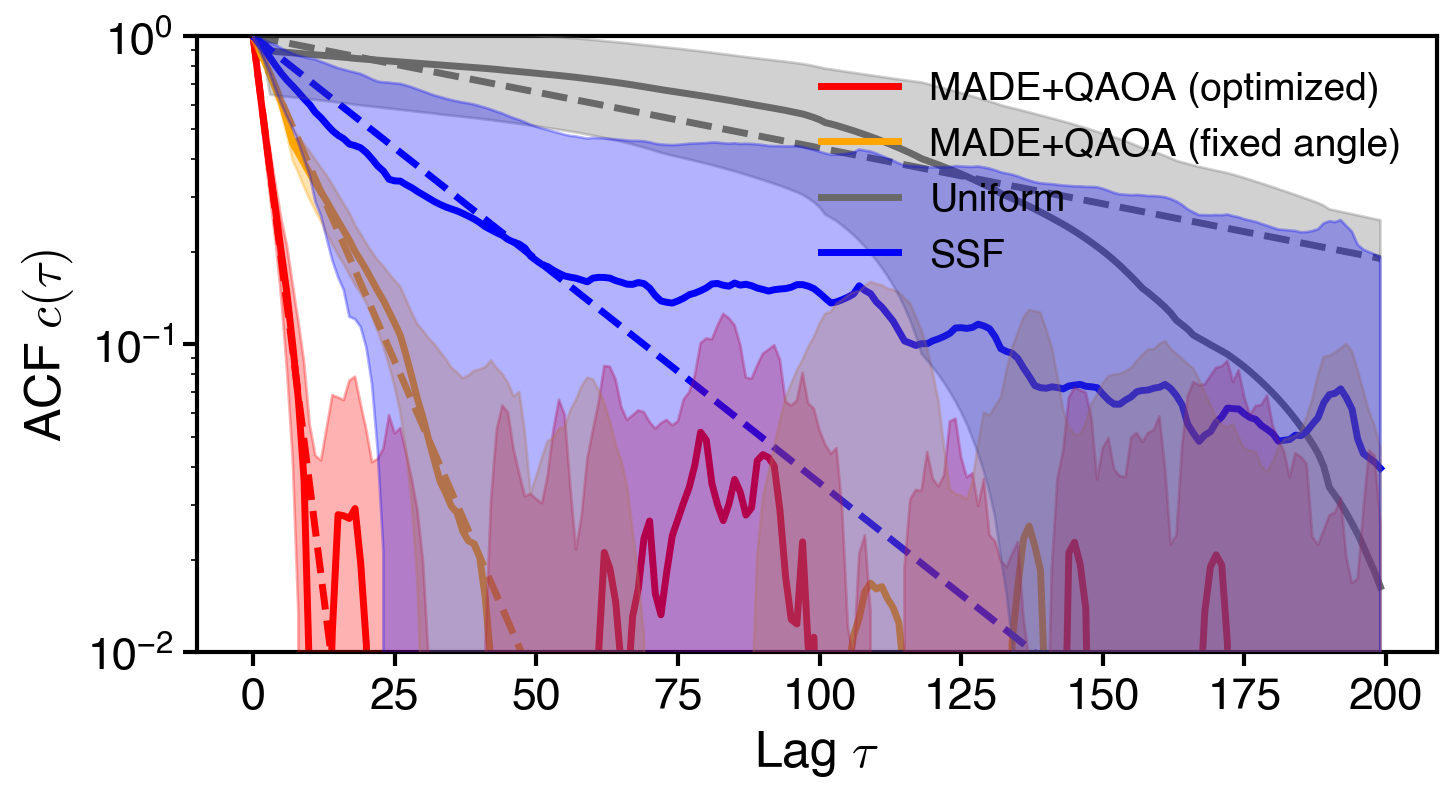

In [27]:
fig4, ax4 = plt.subplots(figsize=(8,4), dpi=200)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5

ax4.spines["top"].set_linewidth(spines)
ax4.spines["left"].set_linewidth(spines)
ax4.spines["bottom"].set_linewidth(spines)
ax4.spines["right"].set_linewidth(spines)

ax4.plot(np.arange(lag), energy_acf_opt_made_ave, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)')
ax4.plot(np.arange(lag), opt_fit, color='red', linewidth=linewidth, linestyle='--')
ax4.fill_between(np.arange(lag), energy_acf_opt_made_ave+energy_acf_opt_made_std, energy_acf_opt_made_ave-energy_acf_opt_made_std, color='red', alpha=0.3, zorder=4)
ax4.plot(np.arange(lag), energy_acf_fix_made_ave, color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax4.plot(np.arange(lag), fix_fit, color='orange', linewidth=linewidth, linestyle='--')
ax4.fill_between(np.arange(lag), energy_acf_fix_made_ave+energy_acf_fix_made_std, energy_acf_fix_made_ave-energy_acf_fix_made_std, color='orange', alpha=0.3, zorder=4)
ax4.plot(np.arange(lag), energy_acf_uni_ave, color='dimgrey', linewidth=linewidth, label='Uniform')
ax4.plot(np.arange(lag), uni_fit, color='dimgrey', linewidth=linewidth, linestyle='--')
ax4.fill_between(np.arange(lag), energy_acf_uni_ave+energy_acf_uni_std, energy_acf_uni_ave-energy_acf_uni_std, color='dimgrey', alpha=0.3, zorder=4)
ax4.plot(np.arange(lag), energy_acf_ssf_ave, color='blue', linewidth=linewidth, label='SSF')
ax4.plot(np.arange(lag), ssf_fit, color='blue', linewidth=linewidth, linestyle='--')
ax4.fill_between(np.arange(lag), energy_acf_ssf_ave+energy_acf_ssf_std, energy_acf_ssf_ave-energy_acf_ssf_std, color='blue', alpha=0.3, zorder=4)

ax4.axhline(0.0, color='black', linestyle='--', linewidth=linewidth)

#ax4.set_xlim(0, lag-1)
ax4.set_ylim(1e-2, 1e0)
ax4.set_yscale('log')
ax4.set_xlabel(r'Lag $\tau$', fontsize=18)
ax4.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax4.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax4.tick_params(axis="x", which='major', width=1.5)
ax4.legend(fontsize=14, loc='upper right', frameon=False)

In [29]:
print(r'$\delta$ (opt): {0}'.format(1 - np.exp(-1.0*opt_popt[0])))
print(r'$\delta$ (fix): {0}'.format(1 - np.exp(-1.0*fix_popt[0])))
print(r'$\delta$ (Uniform): {0}'.format(1 - np.exp(-1.0*uni_popt[0])))
print(r'$\delta$ (SSF): {0}'.format(1 - np.exp(-1.0*ssf_popt[0])))

print(r'$\delta$ (opt): {0}'.format(gap[0]))
print(r'$\delta$ (fix): {0}'.format(gap[1]))
print(r'$\delta$ (Uniform): {0}'.format(gap[2]))
print(r'$\delta$ (SSF): {0}'.format(gap[3]))

$\delta$ (opt): 0.28528142685628444
$\delta$ (fix): 0.09264350232201668
$\delta$ (Uniform): 0.008313001524685504
$\delta$ (SSF): 0.03284622112246005
$\delta$ (opt): 0.34081377528906787
$\delta$ (fix): 0.08281143563786308
$\delta$ (Uniform): 0.002764713708946487
$\delta$ (SSF): 1.4830008389088434e-06
